# TODO

3. make visualizations to potentially eliminate attribute
4. ~~make visualization of classifications to potentially include "distinction" as a subset of pass or withdraw as a subset of fail~~
5. make whole API thing
6. make and prepare for Final presentation (five min)

# Introduction

From our dataset, we will be using the attributes gender, region, highest_education, age_band, num_of_prev_attempts, studied_credits, imd_band$^1$, disability to predict the classifier final_result.

## Cleaning our data

###  Data Analysis
Todo:
* Frequency Bar Charts 
* Relevant summary statistics about the dataset.


Because studied_credits, and num_of_prev_attempts are numerical attributes. We will convert them to categorical. The table below denotes how studied_credits will be converted, and num_of_prev_attempts will be converted to a bool where True denotes that the class has been previously attempted, and False denotes that it has not. 

|number|credit ranges|
|------|-------------|
|1|$\leq$ 59|
|2|60-119|
|3|120-179|
|4|180-239|
|5|$\geq$ 240 |

We further cleaned our data by dropping rows with missing values. We understand that this could impact the affects of our data as we would me losing out on some entries. However, upon further inspection we came to realize that only about 1,000 of the over 30,000 rows of data contained missing values. This small ratio made us sure that losing out on this data would not have a negative impact on our classifier. 

1: imd_band is a measure of poverty based on area in the UK.



In [69]:
import importlib

from tabulate import tabulate
import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

student_data = MyPyTable().load_from_file("input_data/studentInfo.csv")

# remove missing values
student_data.remove_rows_with_missing_values()

gender = student_data.get_column("gender")
region = student_data.get_column("region")
highest_education = student_data.get_column("highest_education") 
age_band = student_data.get_column("age_band")
num_of_prev_attempts = student_data.get_column("num_of_prev_attempts") 
studied_credits = student_data.get_column("studied_credits")

myutils.convert_vals_into_cutoffs(num_of_prev_attempts, [0, 1], [False, True])
myutils.convert_vals_into_cutoffs(studied_credits, [59, 60, 120, 180, 240,], [1,2,3,4,5])

for i in range(len(student_data.data)):
    student_data.data[i][8] = num_of_prev_attempts[i]
    student_data.data[i][9] = studied_credits[i]

imd_band = student_data.get_column("imd_band")
disability = student_data.get_column("disability")


As can be seen in the visualization below, the "distinction" value of the class is not very prevelent. Since students who received a "distinction" final result passed the class we will include distinction into our "pass" category to try and limit our classifier domain. To make the classifier more evenly distributed, we will also include a "fail" and "withdrawn" final result as of the same class since they both have the same end result— the student does not receive credit for the course. The end result of our changes can be seen in the second bar chart below. 

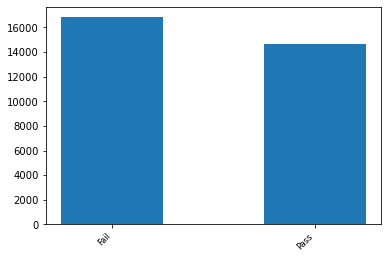

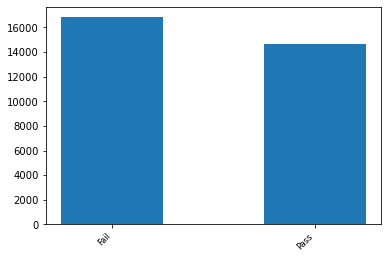

In [71]:
values, counts = myutils.get_frequencies(student_data.data, student_data.column_names, "final_result")
myutils.bar_chart(values, counts)

myutils.replace_values_in_column("Withdrawn", "Fail", student_data.data, student_data.column_names, "final_result")
myutils.replace_values_in_column("Distinction", "Pass", student_data.data, student_data.column_names, "final_result")

values, counts = myutils.get_frequencies(student_data.data, student_data.column_names, "final_result")
myutils.bar_chart(values, counts)
final_result = student_data.get_column("final_result")

## Classifications

### Accuracy Rates
For the purposes of this demo, we ran our, now clean, data through our decisions tree classifiers and naive bayes classifier. Naive Bayes is a bit more accurate than decision tree and our accuracy was a bit disappointing. We are hoping that our RandomForestClassifier will solve some of the overfitting and improve our accuracy rate for our final project.  

In [73]:
# get a smaller subsection of data to run tests over
student_attributes = [x[3:10] for x in student_data.data]
#print(student_attributes)
subsample, _ = myevaluation.random_stratified_test_remainder_set(student_attributes, final_result, 3, set_size=0.33)

subsample_attributes = [x[3:10] for x in subsample]
subsample_result = [x[-1] for x in subsample]

student_train_folds, student_test_folds = myevaluation.stratified_kfold_cross_validation(subsample_attributes, subsample_result, 10) 

student_test = []
student_train = []

final_results_test = []
final_results_train = []

# turn indexes into data sets
for row in student_train_folds:
    student_set = []
    final_results_set = []
    for item in row:
        student_set.append(subsample_attributes[item])
        final_results_set.append(subsample_result[item])
    student_train.append(student_set)
    final_results_train.append(final_results_set)

# turn indexes into data sets
for row in student_test_folds:
    student_set = []
    final_results_set = []
    for item in row:
        student_set.append(subsample_attributes[item])
        final_results_set.append(subsample_result[item])
    student_test.append(student_set)
    final_results_test.append(final_results_set)

#Naive Bayes model
total_Naive = []
total_expected = []
for i in range(10):
    student_Naive = MyNaiveBayesClassifier()    
    student_Naive.fit(student_train[i],final_results_train[i])
    Naive_predictions = student_Naive.predict(student_test[i])
    total_Naive.extend(Naive_predictions)
    total_expected.extend(final_results_test[i])
print("===========================================")
print("Predictive Accuracy")
print("===========================================")
print("Stratified 10-Fold Cross Validation")
accuracy, errorrate = myutils.accuracy_errorrate(total_Naive, total_expected)
print("Naive Bayes: accuracy = ", accuracy, "error rate = ", errorrate)

#Tree model
total_tree = []
total_expected = []
for i in range(10):
    student_tree = MyDecisionTreeClassifier()    
    student_tree.fit(student_train[i],final_results_train[i])
    tree_predictions = student_tree.predict(student_test[i])
    total_tree.extend(tree_predictions)
    total_expected.extend(final_results_test[i])



accuracy, errorrate = myutils.accuracy_errorrate(total_tree, total_expected)
print("Tree: accuracy = ", accuracy, "error rate = ", errorrate)

#Random Forest Model
total_random_forest = []
total_expected_forest = []
for i in range(10):
    student_random_forest = MyRandomForestClassifier()    
    student_random_forest.fit(student_train[i],final_results_train[i], 5, 20, 7)
    forest_predictions = student_random_forest.predict(student_test[i])
    total_random_forest.extend(forest_predictions)
    total_expected_forest.extend(final_results_test[i])
accuracy, errorrate = myutils.accuracy_errorrate(total_random_forest, total_expected_forest)
print("Random Forest: accuracy = ", accuracy, "error rate = ", errorrate)

Predictive Accuracy
Stratified 10-Fold Cross Validation
Naive Bayes: accuracy =  1.0 error rate =  0.0
Tree: accuracy =  0.5160091480846197 error rate =  0.4839908519153802
Random Forest: accuracy =  1.0 error rate =  0.0


### Confusion Matrix

We then made a confusion matrix for our decision tree classifier to see how our predicitions were distributed. It shows how the predictions are not clustered along the diagonal and this is due to the classifier's inaccuracies. 

In [75]:
tree_matrix = myevaluation.confusion_matrix(total_expected, total_tree, ["Pass","Fail"])

for i in range(len(tree_matrix)):
    total = 0
    rec = 0
    for item in tree_matrix[i]:
        total += item
    true_pos = tree_matrix[i][i]
    if total != 0:
        rec = (true_pos/total)*100
    tree_matrix[i].append(total)
    tree_matrix[i].append(rec)

tree_matrix[0].insert(0, "Pass")
tree_matrix[1].insert(0, "Fail")

print()
print("Decision Tree (Stratified 10 Fold Cross Validation Results)")
print(tabulate(tree_matrix, ["Final Result","Pass","Fail","total", "Recognition %"]))



Decision Tree (Stratified 10 Fold Cross Validation Results)
Final Result      Pass    Fail    total    Recognition %
--------------  ------  ------  -------  ---------------
Pass               825    4060     4885          16.8884
Fail              1019    4590     5609          81.8328
